In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import configparser
import datetime
import talib
from datetime import datetime, timedelta

In [2]:
# データ読み込み #
df = pd.read_csv('usdjpy_d1010.csv')

In [3]:
df['Date']=pd.to_datetime(df['Date'])

In [4]:
df['SMA20']=talib.SMA(df['Close'],timeperiod=20)
df['RSI']=talib.RSI(df['Close'],timeperiod=14)

In [5]:
df.drop(range(0,19),inplace=True)

In [6]:
df.head(10)

,Date,Open,High,Low,Close,SMA20,RSI
19,2017-01-31,113.739,113.962,112.087,112.674,114.64640,36.726650
20,2017-02-01,112.674,113.954,112.657,113.287,114.44710,39.640498
21,2017-02-02,113.287,113.363,112.060,112.864,114.31805,38.328794
22,2017-02-03,112.866,113.454,112.326,112.694,114.10295,37.787617
23,2017-02-06,112.561,112.772,111.629,111.817,113.89810,35.039076
24,2017-02-07,111.803,112.511,111.604,112.315,113.72220,37.805503
25,2017-02-08,112.315,112.545,111.643,111.845,113.54395,36.237044
26,2017-02-09,111.847,113.351,111.843,113.315,113.47520,44.054845
27,2017-02-10,113.314,113.857,112.861,113.357,113.41550,44.265106
28,2017-02-13,113.646,114.169,113.455,113.765,113.39955,46.373597


In [7]:
df.shape

(698, 7)

In [8]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'SMA20', 'RSI'], dtype='object')

In [9]:
df.tail(10)

,Date,Open,High,Low,Close,SMA20,RSI
707,2019-09-27,107.838,108.181,107.659,107.960,107.47885,57.272176
708,2019-09-30,107.987,108.179,107.746,108.079,107.57305,58.540443
709,2019-10-01,108.079,108.464,107.629,107.762,107.66440,53.946746
710,2019-10-02,107.763,107.893,107.058,107.165,107.70430,46.539926
711,2019-10-03,107.160,107.299,106.503,106.874,107.70025,43.411173
712,2019-10-04,106.878,107.126,106.585,106.847,107.69615,43.121508
713,2019-10-07,106.676,107.457,106.676,107.236,107.69555,48.457661
714,2019-10-08,107.234,107.441,106.815,107.072,107.67315,46.477931
715,2019-10-09,107.073,107.626,106.935,107.466,107.65565,51.594461
716,2019-10-10,107.463,108.016,107.038,107.868,107.64460,56.195692


In [10]:
# トレーニングデータと予測用データに分ける（train：、test：10）
# テストデータの最初の10件（latest）を使って残りの10件の予測をする
split_date = '2019-09-27'
train,latest= df[df['Date']<split_date],df[df['Date']>=split_date]

In [11]:
latest

,Date,Open,High,Low,Close,SMA20,RSI
707,2019-09-27,107.838,108.181,107.659,107.960,107.47885,57.272176
708,2019-09-30,107.987,108.179,107.746,108.079,107.57305,58.540443
709,2019-10-01,108.079,108.464,107.629,107.762,107.66440,53.946746
710,2019-10-02,107.763,107.893,107.058,107.165,107.70430,46.539926
711,2019-10-03,107.160,107.299,106.503,106.874,107.70025,43.411173
712,2019-10-04,106.878,107.126,106.585,106.847,107.69615,43.121508
713,2019-10-07,106.676,107.457,106.676,107.236,107.69555,48.457661
714,2019-10-08,107.234,107.441,106.815,107.072,107.67315,46.477931
715,2019-10-09,107.073,107.626,106.935,107.466,107.65565,51.594461
716,2019-10-10,107.463,108.016,107.038,107.868,107.64460,56.195692


In [12]:
del train['Date']
del latest['Date']

In [13]:
train.shape, latest.shape

((688, 6), (10, 6))

In [14]:
#windowを設定
window_len = 10
#latest = test[:window_len]
#length = len(test)- window_len

In [15]:
latest

,Open,High,Low,Close,SMA20,RSI
707,107.838,108.181,107.659,107.960,107.47885,57.272176
708,107.987,108.179,107.746,108.079,107.57305,58.540443
709,108.079,108.464,107.629,107.762,107.66440,53.946746
710,107.763,107.893,107.058,107.165,107.70430,46.539926
711,107.160,107.299,106.503,106.874,107.70025,43.411173
712,106.878,107.126,106.585,106.847,107.69615,43.121508
713,106.676,107.457,106.676,107.236,107.69555,48.457661
714,107.234,107.441,106.815,107.072,107.67315,46.477931
715,107.073,107.626,106.935,107.466,107.65565,51.594461
716,107.463,108.016,107.038,107.868,107.64460,56.195692


In [16]:
# LSTMへの入力用に処理の関数
def data_maker(data):
  data_lstm_in=[]
  if len(data)==window_len:
    temp = data[:window_len].copy()
    temp = temp / temp.iloc[0] - 1
    data_lstm_in.append(temp)
  for i in range(len(data) - window_len):
      temp = data[i:(i + window_len)].copy()
      temp = temp / temp.iloc[0] - 1
      data_lstm_in.append(temp)
  return data_lstm_in

In [17]:
# LSTMへの入力用に処理（訓練）
train_lstm_in = []
for i in range(len(train) - window_len):
    temp = train[i:(i + window_len)].copy()
    for col in train:
        temp.loc[:, col] = temp[col] / temp[col].iloc[0] - 1
    train_lstm_in.append(temp)

lstm_train_out = (train['Close'][window_len:].values / train['Close'][:-window_len].values)-1

In [18]:
# LSTMへの入力用に処理（テスト）
#test_lstm_in = []
#for i in range(len(test) - window_len):
#    temp = test[i:(i + window_len)].copy()
#    for col in test:
#        temp.loc[:, col] = temp[col] / temp[col].iloc[0] - 1
#    test_lstm_in.append(temp)

#lstm_test_out = (test['Close'][window_len:].values / test['Close'][:-window_len].values)-1

latest_lstm_in = data_maker(latest)

In [19]:
latest_lstm_in

[         Open      High       Low     Close     SMA20       RSI
 707  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
 708  0.001382 -0.000018  0.000808  0.001102  0.000876  0.022145
 709  0.002235  0.002616 -0.000279 -0.001834  0.001726 -0.058064
 710 -0.000695 -0.002662 -0.005582 -0.007364  0.002098 -0.187390
 711 -0.006287 -0.008153 -0.010738 -0.010059  0.002060 -0.242020
 712 -0.008902 -0.009752 -0.009976 -0.010309  0.002022 -0.247078
 713 -0.010775 -0.006692 -0.009131 -0.006706  0.002016 -0.153906
 714 -0.005601 -0.006840 -0.007840 -0.008225  0.001808 -0.188473
 715 -0.007094 -0.005130 -0.006725 -0.004576  0.001645 -0.099136
 716 -0.003477 -0.001525 -0.005768 -0.000852  0.001542 -0.018796]

In [20]:
# PandasのデータフレームからNumpy配列へ変換
def pd_to_np(data_lstm_in):
  data_lstm_in = [np.array(data_lstm_input) for data_lstm_input in data_lstm_in]
  data_lstm_in = np.array(data_lstm_in)
  return data_lstm_in
train_lstm_in = pd_to_np(train_lstm_in)
latest_lstm_in = pd_to_np(latest_lstm_in)

In [21]:
# Kerasの使用するコンポーネントをインポートしましょう
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [22]:
# LSTMのモデルを設定
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
 
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
 
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [24]:
# ランダムシードの設定
np.random.seed(205)
 
# 初期モデルの構築
yen_model = build_model(train_lstm_in, output_size=1, neurons = 20)
 
# データを流してフィッティングさせましょう
yen_history = yen_model.fit(train_lstm_in, lstm_train_out, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 3s - loss: 0.0125
Epoch 2/50
 - 2s - loss: 0.0070
Epoch 3/50
 - 2s - loss: 0.0059
Epoch 4/50
 - 2s - loss: 0.0053
Epoch 5/50
 - 2s - loss: 0.0053
Epoch 6/50
 - 2s - loss: 0.0050
Epoch 7/50
 - 2s - loss: 0.0048
Epoch 8/50
 - 2s - loss: 0.0046
Epoch 9/50
 - 2s - loss: 0.0047
Epoch 10/50
 - 2s - loss: 0.0047
Epoch 11/50
 - 2s - loss: 0.0043
Epoch 12/50
 - 2s - loss: 0.0045
Epoch 13/50
 - 2s - loss: 0.0046
Epoch 14/50
 - 2s - loss: 0.0043
Epoch 15/50
 - 2s - loss: 0.0043
Epoch 16/50
 - 2s - loss: 0.0044
Epoch 17/50
 - 2s - loss: 0.0043
Epoch 18/50
 - 2s - loss: 0.0044
Epoch 19/50
 - 2s - loss: 0.0043
Epoch 20/50
 - 2s - loss: 0.0045
Epoch 21/50
 - 2s - loss: 0.0044
Epoch 22/50
 - 2s - loss: 0.0044
Epoch 23/50
 - 2s - loss: 0.0043
Epoch 24/50
 - 3s - loss: 0.0042
Epoch 25/50
 - 2s - loss: 0.0044
Epoch 26/50
 - 2s - loss: 0.0042
Epoch 27/50
 - 2s - loss: 0.0042
Epoch 28/50
 - 2s - loss: 0.0041
Epoch 29/50
 - 2s - loss: 0.0043
Epoch 30/50
 - 2s - loss: 0.0043
Epoch 31/50
 - 2s -

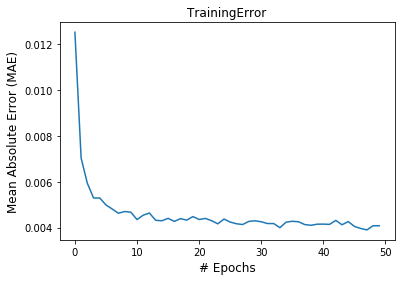

In [25]:
# MAEをプロットしてみよう
fig, ax1 = plt.subplots(1,1)
 
ax1.plot(yen_history.epoch, yen_history.history['loss'])
ax1.set_title('TrainingError')
 
if yen_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698 entries, 19 to 716
Data columns (total 7 columns):
Date     698 non-null datetime64[ns]
Open     698 non-null float64
High     698 non-null float64
Low      698 non-null float64
Close    698 non-null float64
SMA20    698 non-null float64
RSI      698 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 43.6 KB


In [27]:
df[df['Date']< split_date]['Date'][window_len:]

29    2017-02-14
30    2017-02-15
31    2017-02-16
32    2017-02-17
33    2017-02-20
         ...    
702   2019-09-20
703   2019-09-23
704   2019-09-24
705   2019-09-25
706   2019-09-26
Name: Date, Length: 678, dtype: datetime64[ns]

C:\Users\ISP_61860\Anaconda3\envs\py36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


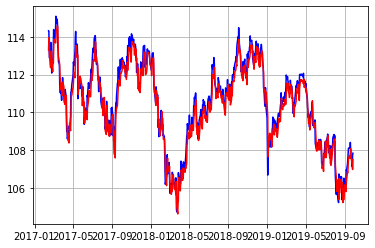

In [28]:
# 訓練データから予測をして正解レートと予測したレートをプロット
fig, ax1 = plt.subplots(1,1)
ax1.plot(df[df['Date']< split_date]['Date'][window_len:],
         train['Close'][window_len:], label='Actual', color='blue')
ax1.plot(df[df['Date']< split_date]['Date'][window_len:],
         ((np.transpose(yen_model.predict(train_lstm_in))+1) * train['Close'].values[:-window_len])[0], 
         label='Predicted', color='red')
ax1.grid(True)

In [29]:
#予測値
empty = []
future_array = np.array(empty)
# 10回分予測する
length = 10
# 予測する長さ分繰り返す
for i in range(length):
  # 正規化された値で予測されるので値を戻す
  pred = (((np.transpose(yen_model.predict(latest_lstm_in))+1) * latest['Close'].values[0])[0])[0]
  # 予測した値を格納
  future_array= np.append(future_array,pred)
  ## 以下は予測結果をLSTMの型に変換するための処理、予測した結果を繋げて次を予測する
  # 予測した値をcloseに設定
  data ={'Close':[pred]}
  # データフレームに変換
  df1 = pd.DataFrame(data)
  # latastに予測値を設定
  latest =pd.concat([latest,df1],axis=0)
  # インデックスを設定する（0から並べ直す）
  latest.index = range(0,window_len+1)
  # 最初の値を削除する
  latest = latest.drop(0,axis=0)
  # numpyに変換（必要？）
  latest_lstm_in =pd_to_np(latest_lstm_in)

C:\Users\ISP_61860\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [30]:
print(future_array)

[107.56391907 107.68248749 107.36664581 106.77183533 106.48190308
 106.45500183 106.84257507 106.67917633 107.07173157 107.47225189]


In [31]:
test= df[df['Date']>=split_date]

In [36]:
test

,Date,Open,High,Low,Close,SMA20,RSI
707,2019-09-27,107.838,108.181,107.659,107.960,107.47885,57.272176
708,2019-09-30,107.987,108.179,107.746,108.079,107.57305,58.540443
709,2019-10-01,108.079,108.464,107.629,107.762,107.66440,53.946746
710,2019-10-02,107.763,107.893,107.058,107.165,107.70430,46.539926
711,2019-10-03,107.160,107.299,106.503,106.874,107.70025,43.411173
712,2019-10-04,106.878,107.126,106.585,106.847,107.69615,43.121508
713,2019-10-07,106.676,107.457,106.676,107.236,107.69555,48.457661
714,2019-10-08,107.234,107.441,106.815,107.072,107.67315,46.477931
715,2019-10-09,107.073,107.626,106.935,107.466,107.65565,51.594461
716,2019-10-10,107.463,108.016,107.038,107.868,107.64460,56.195692


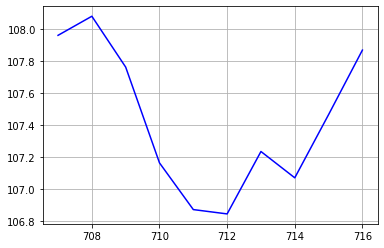

In [33]:
fig, ax1 = plt.subplots(1,1)
plt.plot(test.index,
        test['Close'], label='Actual', color='blue')
ax1.grid(True)

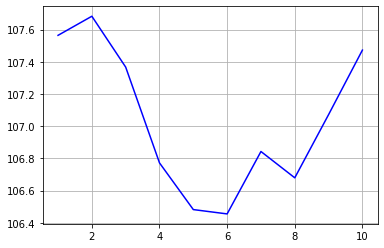

In [34]:
# 今後の予想の動き
fig, ax1 = plt.subplots(1,1)
ax1.plot(latest.index,
         future_array, label='Actual', color='blue')
ax1.grid(True)

In [35]:
latest['Close']

1     107.563919
2     107.682487
3     107.366646
4     106.771835
5     106.481903
6     106.455002
7     106.842575
8     106.679176
9     107.071732
10    107.472252
Name: Close, dtype: float64